# Solution: A separate compartment for vaccination

Your model structure and initial conditions should look like this:

<img src="w5_nb2_diagram.png"> 

\begin{align}
S0 & = (1-p) N \\
I0 & = 1 \\
R0 & = 0 \\
V0 & = p N
\end{align}

where *p* is the effective vaccination coverage and N is the total population size

This translates to the following code:

In [1]:
# LOAD THE PACKAGES:
library(deSolve)
library(reshape2)
library(ggplot2)

# MODEL INPUTS:

# Specify the total population size
N <- 1000000

# Specify the vaccination coverage
p <- 0.3

# Initial number of people in each compartment
initial_state_values <- c(S = (1-p)*N,      # the unvaccinated proportion of the population is susceptible
                          I = 1,            # the epidemic starts with a single infected person
                          R = 0,            # there is no prior immunity in the population
                          V = p*N)          # a proportion p of the population is vaccinated (vaccination coverage) 

# Parameters describing the transition rates in units of days^-1
parameters <- c(beta = 0.5,       # the infection rate
                gamma = 0.1)      # the rate of recovery

# TIMESTEPS:

# Sequence of timesteps to solve the model at
times <- seq(from = 0, to = 100, by = 1)   # from 0 to 100 days in daily intervals

# MODEL FUNCTION: 

vaccine_model <- function(time, state, parameters) {  

    with(as.list(c(state, parameters)), {    
        
    # Defining lambda as a function of beta and I:
      lambda <- beta * I/N
        
    # The differential equations
      dS <- -lambda * S            
      dI <- lambda * S - gamma * I 
      dR <- gamma * I
      dV <- 0                          # the number in the V compartment should stay the same over the whole simulation,
                                       # so the rate of change equals 0
      
    # Return the number of people in each compartment at each timestep 
    # (in the same order as the input state variables)
    return(list(c(dS, dI, dR, dV))) 
    })
  
}

# MODEL OUTPUT:

# Solving the differential equations using the ode integration algorithm
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = vaccine_model,
                            parms = parameters))

**Plot the output to check that the code works:**

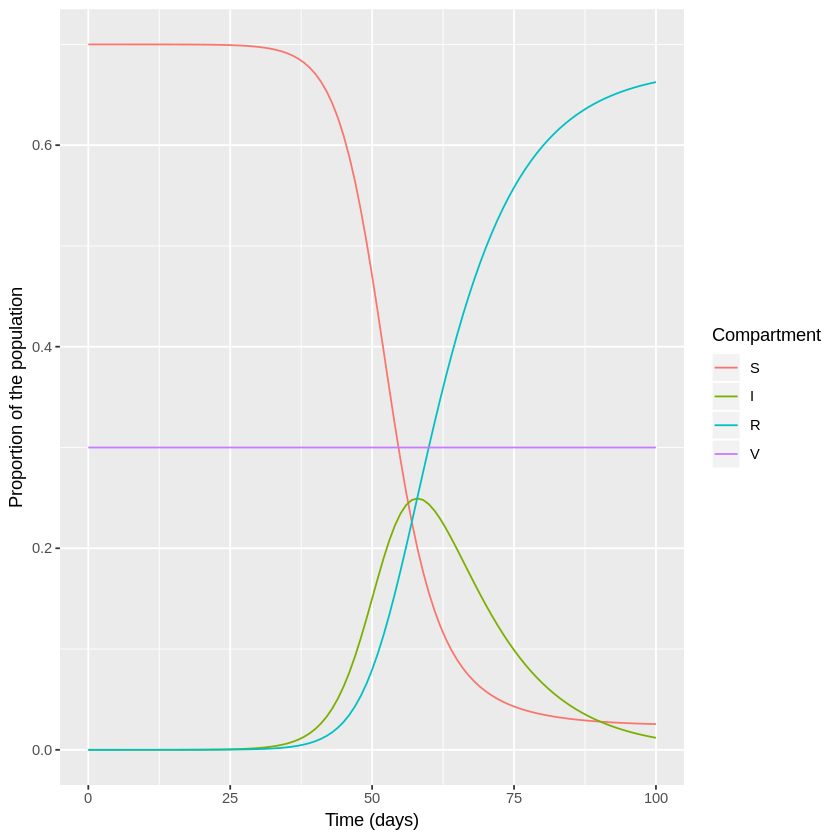

In [2]:
output_long <- melt(as.data.frame(output), id = "time")                  # turn output dataset into long format

# Adding a column for the prevalence proportion to the long-format output
output_long$prevalence <- output_long$value/sum(initial_state_values)

# Plot the number in each compartment over time
ggplot(data = output_long,                                               
       aes(x = time, y = prevalence, colour = variable, group = variable)) +  
  geom_line() +                                                          
  xlab("Time (days)")+                                                   
  ylab("Proportion of the population") +                                      
  labs(colour = "Compartment")   

Our code gives a sensible output: 
- if we chose no or a low vaccination coverage, we see an epidemic as we would expect given our choice of $\beta$ and $\gamma$ (R<sub>0</sub> = 0.5/0.1 = 5)
- if we chose a vaccination coverage over the herd immunity threshold of 80% (> 1-1/R<sub>0</sub>), no epidemic occurs
- the proportion of the population in the vaccinated compartment V stays constant over time

### Note: Why do we need to specify V in the differential equations at all?

You might wonder why we specify the rate of change in the vaccinated compartment in our differential equations, despite this not changing over time. This is purely for practical reasons using deSolve. Technically all we need is to define the initial number of people in V, but remember that using deSolve, we need to return/output the rate of change variables at the end of the model function corresponding to the same order of variables in the initial_state_values vector. So by having V in the initial conditions, we also have to output its rate of change from the model function, else ```deSolve::ode()``` will print an error message saying ```"The number of derivatives returned by func() must equal the length of the initial conditions vector"```.